In [93]:
import os
import numpy as np
import tensorflow as tf
from typing import Sequence, Optional, Union
import math
import helpers.input_processor as ip
import polars as pl
import matplotlib.pyplot as plt
import librosa

In [94]:
def balanceData(df, method):
    if method==1:
        #balance the data so that there is an equal number of murmur positive and murmur negative samples
        #do this by duplicating random rows of whichever group (pos or neg) is smaller
        neg_df = df.filter(pl.col('label')==0.0)
        pos_df = df.filter(pl.col('label')==1.0)
        numNeg = neg_df.height
        numPos = pos_df.height

        while numNeg != numPos:
            if numNeg < numPos:
                df.vstack(neg_df.sample(n=min(numPos-numNeg, neg_df.height), shuffle=True), in_place=True)
            else: 
                df.vstack(pos_df.sample(n=min(numNeg-numPos, pos_df.height), shuffle=True), in_place=True)
            numNeg = df.filter(pl.col('label')==0.0).height
            numPos = df.filter(pl.col('label')==1.0).height

        #reshuffle rows
        df = df.sample(frac=1.0, shuffle=True)

        #check number of positive and negative samples
        numNeg = df.filter(pl.col('label')==0.0).height
        numPos = df.filter(pl.col('label')==1.0).height
        print('Total Samples:       ', df.height)
        print('Positive Samples:    ', numPos)
        print('Negative Samples:    ', numNeg)
        print('Percent Positive Samples:    ', numPos/(numPos+numNeg))
    elif method==2:
        #balance the data so that there is an equal number of murmur positive and murmur negative samples
        #do this by filtering out rows of whichever group (pos or neg) is larger
        neg_df = df.filter(pl.col('label')==0.0)
        pos_df = df.filter(pl.col('label')==1.0)
        numNeg = neg_df.height
        numPos = pos_df.height

        if numNeg < numPos:
            df = neg_df.vstack(pos_df.sample(n=numNeg))
        elif numPos < numNeg:
            df = pos_df.vstack(neg_df.sample(n=numPos))
        else:
            df = neg_df.vstack(pos_df)

        #reshuffle rows
        df = df.sample(frac=1.0, shuffle=True)

        #check number of positive and negative samples
        numNeg = df.filter(pl.col('label')==0.0).height
        numPos = df.filter(pl.col('label')==1.0).height
        print('Total Samples:       ', df.height)
        print('Positive Samples:    ', numPos)
        print('Negative Samples:    ', numNeg)
        print('Percent Positive Samples:    ', numPos/(numPos+numNeg))
    else:
        raise Exception(f'Received unexpected input to \'method\' parameter: {method}')

    return df

In [95]:
class input(object):
    def __init__(self, filePaths:Sequence[str], labels:Sequence[float], startTimes:Optional[Sequence[float]]=None, endTimes:Optional[Sequence[float]]=None, batchSize:Optional[int]=None, duration:Union[float,str]=10, sr:int=4000, augmentData:bool=False):
        # Check that data has consistent shape
        cols = [filePaths, labels, startTimes, endTimes]
        if any(len(col)!=len(cols[0]) for col in cols if col is not None):
            raise Exception(f'Expected lists with equal length, but received lists with lengths {[len(col) for col in cols if col is not None]}')
        # Check that startTime and endTime are either both specified or both unspecified (assuming both are either a sequence of float or None)
        if type(startTimes)!=type(endTimes):
            raise Exception(f'startTimes and endTimes must either both have type Sequence[float] or both be None, but received startTimes with type {type(startTimes)} and endTimes with type {type(endTimes)}.')
        # Check that batch size is not larger than the total amount of data
        if batchSize is not None and batchSize > len(filePaths):
            raise Exception(f'batchSize={batchSize} cannot be larger than the length of filePaths')

        self.filePaths = filePaths
        self.labels = labels
        self.startTimes = startTimes if startTimes is not None else [None]*len(filePaths)
        self.endTimes = endTimes if endTimes is not None else [None]*len(filePaths)

        self.totalSize = len(filePaths)
        self.batchSize = batchSize
        self.numBatches = math.floor(self.totalSize / batchSize) if batchSize is not None else 0
        self.sr = sr
        self.duration = float(duration)
        self.augmentData = augmentData

    @classmethod
    def fromPolars(cls, df, batchSize:Optional[int]=None, duration:Union[float,str]=10, sr:int=4000, augmentData:bool=False):
        for col in ['filePaths', 'labels', 'startTimes', 'endTimes']:
            if col not in df.columns:
                raise Exception(f'Column \'{col}\' not found in dataframe with colums {df.columns}')
        return cls(
            filePaths=df.get_column('filePaths').to_list(),
            labels=df.get_column('labels').to_list(),
            startTimes=df.get_column('startTimes').to_list(),
            endTimes=df.get_column('endTimes').to_list(),
            batchSize=batchSize,
            duration=duration,
            sr=sr,
            augmentData=augmentData
        )

    def dataset(self) -> tf.data.Dataset:
        try:
            out = self.__dataset
        except AttributeError:
            datasetCols = (self.filePaths, self.labels, self.startTimes, self.endTimes)
            self.__dataset = (
                tf.data.Dataset.from_tensor_slices(datasetCols)
                .map(self.preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
            )
            out = self.__dataset
        return out

    def preprocessor(self, filePath, label, startTime, endTime):
        sr = tf.constant(self.sr, dtype=tf.float32)

        # Load and decode audio file
        encodedAudio = tf.io.read_file(filePath)
        rawAudio, _ = tf.audio.decode_wav(encodedAudio)
        rawAudio = tf.squeeze(rawAudio)

        # If specified, extract the sample from the audio file using startTime and endTime.
        # Otherwise, use the entire audio file as the sample.
        if startTime is None or endTime is None:
            audio = rawAudio
        else:
            startInd = tf.cast(tf.math.floor((startTime*sr)), tf.int32)
            endInd = tf.cast(tf.math.floor((endTime*sr)), tf.int32)
            audio = rawAudio[startInd:endInd]

        # Resize samples to uniform length, either by padding it with silence or truncating it
        trimmedAudio = self.paddedTrim(audio, self.duration, sr)

        # Time shift signal to the left or right by a random percent of its original length (max 99%)
        #   NOT IMPLEMENTED 

        # Convert audio signal to mel spectrogram
        spec = tf.signal.stft(trimmedAudio, frame_length=255, frame_step=128)
        spec = tf.abs(spec)
        # melFilterbank = tf.signal.linear_to_mel_weight_matrix(sample_rate=self.sr, upper_edge_hertz=1900) #NOT DONE
        # melSpec = tf.matmul(spec, melFilterbank)
        # melSpec = self.power_to_db(melSpec)

        melSpec = spec

        # Apply time and frequency masking
        #   NOT IMPLEMENTED

        sampleOut = melSpec[..., tf.newaxis]
        labelOut = label
        return sampleOut, labelOut

    def paddedTrim(self, audio, duration, sr):
        originalLength = tf.size(audio)
        trimmedLength = tf.cast(tf.math.floor(duration*sr), tf.int32)
        # Define the range of possible indices where the slice window may start
        startBounds = tf.sort(tf.stack([originalLength-trimmedLength, tf.constant(0)], 0))
        print(startBounds)
        # Pad audio on both sides to the outer possible boundary of the slice window
        padSize = tf.math.abs(startBounds[0])
        paddedAudio = tf.pad(audio, paddings=[[padSize, padSize]])
        # Get a random starting point for the slice window relative to the unpadded audio
        startBounds = tf.cast(startBounds, tf.float32)
        unpaddedStart = tf.math.round(tf.random.uniform(shape=[1], minval=startBounds[0], maxval=startBounds[1]))
        # Slice the audio
        paddedStart = tf.cast(unpaddedStart + tf.cast(padSize, tf.float32), tf.int32)
        shape = tf.reshape(trimmedLength, [1])
        trimmedAudio = tf.slice(paddedAudio, paddedStart, shape)
        return trimmedAudio

    def power_to_db(self, S, amin=1e-16, top_db=80.0):
        """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
        Computes the scaling ``10 * log10(S / max(S))`` in a numerically
        stable way.
        Based on:
        https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
        """
        def _tf_log10(x):
            numerator = tf.math.log(x)
            denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
            return numerator / denominator
        
        # Scale magnitude relative to maximum value in S. Zeros in the output 
        # correspond to positions where S == ref.
        ref = tf.reduce_max(S)

        log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
        log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

        log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

        return log_spec

    def describe(self):
        printout = {
            'Total Size': self.totalSize,
            'Batch Size': self.batchSize,
            'Number of Batches': self.numBatches,
            'Duration (s)': self.duration,
            'Perform data augmentation': self.augmentData
        }
        for key, value in printout.items():
            print(f'{key}: {value}')
            




In [96]:
BATCH_SIZE = 64
NUM_EPOCHS = 50
H = 256
W = 313
DEVICE = 'gpu'

segmentAudio = True

# Load data from dataframe
data_dir = "data/raw_training/training_data/"
df = (
    ip.loadTrainingData(data_dir)
    .filter(pl.col('murmur_in_recording') != 'Unknown')
    .pipe(ip.encodeData)
    .select([
        pl.col('audio_file').apply(lambda x: os.path.join(data_dir, x)).alias('sample'),
        pl.col('murmur_in_recording').alias('label'),
        pl.col('segments')
    ])
)
# Get the start and end time of each sample
if segmentAudio==True:
    df = (
        # Reshape df so that each segment is on its own line
        df.explode('segments').rename({'segments':'segment'})
        # Reformat segment to a list containing the start and end time of the segment as a float
        .with_column(pl.col('segment').str.strip().str.split(by='+').arr.eval(pl.element().cast(pl.Float32)))
        # Replace the segment column with two new columns containing the start and end time of the segment
        .with_columns([
            pl.col('segment').arr.get(0).alias('start_time'),
            pl.col('segment').arr.get(1).alias('end_time')
        ])
        .drop('segment')
    )
else:
    # NOT IMPLEMENTED
    pass
# Package labels, start time, and end time into a single sample_information column
df = df.with_column(pl.concat_str([pl.col(['label', 'start_time', 'end_time'])], sep='+').alias('sample_information'))

# Shuffle data
df = df.sample(frac=1.0, shuffle=True)

# Split data into training, validation, and testing sets
train_df, test_df = ip.splitDataframe(df, split_ratio=0.9)
train_df, val_df = ip.splitDataframe(train_df, split_ratio=0.8)

numTrainBatches = math.ceil(train_df.height / BATCH_SIZE)
numValBatches = math.ceil(val_df.height / BATCH_SIZE)
numTestBatches = math.ceil(test_df.height / BATCH_SIZE)
print(f'Training Set Original Size, Batches:      {train_df.height}, {numTrainBatches}')
print(f'Validation Set Original Size, Batches:    {val_df.height}, {numValBatches}')
print(f'Testing Set Original Size, Batches:       {test_df.height}, {numTestBatches}')

# Balance data so there is an equal number of murmur present and murmur absent samples
train_df = balanceData(train_df, 1)
val_df = balanceData(val_df, 1)
test_df = balanceData(test_df, 1)

numTrainBatches = math.ceil(train_df.height / BATCH_SIZE)
numValBatches = math.ceil(val_df.height / BATCH_SIZE)
numTestBatches = math.ceil(test_df.height / BATCH_SIZE)
print(f'Training Set Final Size, Batches:      {train_df.height}, {numTrainBatches}')
print(f'Validation Set Final Size, Batches:    {val_df.height}, {numValBatches}')
print(f'Testing Set Final Size, Batches:       {test_df.height}, {numTestBatches}')

# check that sets are unique
for set1, set2 in [[train_df, val_df], [train_df, test_df], [val_df, test_df]]:
    col1 = set1.select(pl.concat_str([pl.all().exclude('sample_information')], sep="\t\t").alias('set1Cols')).get_column('set1Cols')
    col2 = set2.select(pl.concat_str([pl.all().exclude('sample_information')], sep="\t\t").alias('set2Cols')).get_column('set2Cols')
    overlap = col1.is_in(col2)
    if overlap.any():
        print(col1.len(), col2.len())
        print(overlap.value_counts())
        problem = col1.filter(overlap)
        raise Exception(
            'Training, validation, and/or testing sets are not unique.' +
            f' Number of overlaps: {col1.filter(overlap).len()}'
        )
    else:
        print('Datasets are unique')

# Rename Columns
rename = lambda df: df.rename({'sample':'filePaths', 'label':'labels', 'start_time':'startTimes', 'end_time':'endTimes'})
train_df = rename(train_df)
val_df = rename(val_df)
test_df = rename(test_df)

loading data from save file:  cache/ingested_data.json
Training Set Original Size, Batches:      44034, 689
Validation Set Original Size, Batches:    11008, 172
Testing Set Original Size, Batches:       6116, 96
Total Samples:        72358
Positive Samples:     36179
Negative Samples:     36179
Percent Positive Samples:     0.5
Total Samples:        18088
Positive Samples:     9044
Negative Samples:     9044
Percent Positive Samples:     0.5
Total Samples:        9956
Positive Samples:     4978
Negative Samples:     4978
Percent Positive Samples:     0.5
Training Set Final Size, Batches:      72358, 1131
Validation Set Final Size, Batches:    18088, 283
Testing Set Final Size, Batches:       9956, 156
Datasets are unique
Datasets are unique
Datasets are unique


In [97]:
train = input.fromPolars(train_df, batchSize=BATCH_SIZE, duration=1)
train.describe()

Total Size: 72358
Batch Size: 64
Number of Batches: 1130
Duration (s): 1.0
Perform data augmentation: False


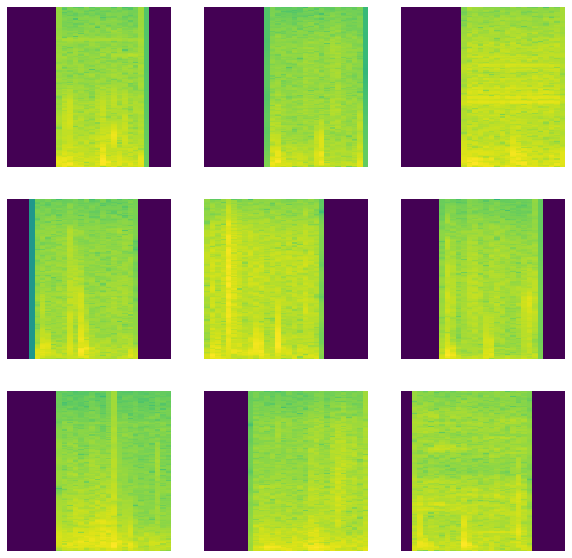

In [100]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(train.dataset().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.axis('off')

plt.show()
